# Imports

In [1]:
from seaexplorertools import process_adcp

# Begin ADCP Data Processing

Set paths to input files and specify options

In [2]:
adcp_path = 'ADCP_refactoring_test_files/sea045_M44.ad2cp.00000*.nc'
glider_pqt_path = 'ADCP_refactoring_test_files/Skag_test.pqt'

options = {
    'debug' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    }


## Load ADCP data and add necessary glider variables

In [3]:
ADCP, data, ADCP_settings, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

Loaded ADCP_refactoring_test_files/Skag_test.pqt
2023-05-23 11:00:43 : Finished loading ADCP data
2023-05-23 11:00:44 : Added glider variables
2023-05-23 11:00:44 : top mounted: True


# Start QC Calculate depth of each individual measurement


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


2023-05-23 11:00:44 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)


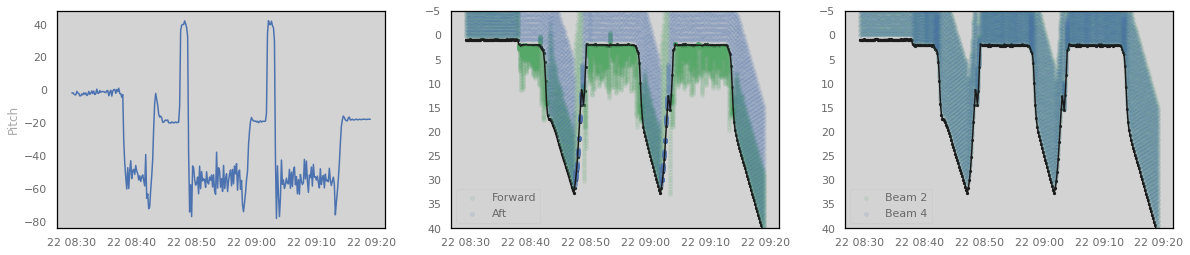

In [4]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

In [5]:
## ADJUST DISTANCE BASED ON SOUNDSPEED !

## Correct ADCP Heading

        <total-intensity units="nT">51039</total-intensity>

Target = 510.39
Optimization terminated successfully.
         Current function value: 2.312568
         Iterations: 956
         Function evaluations: 1359
[[ 8.21005866e-01 -3.83221955e-02 -1.92652097e-02]
 [-5.39439514e-04  8.54898793e-01 -8.35052039e-03]
 [-9.91747987e-03 -5.26418160e-03  8.53100949e-01]]
[ 0.02260588  0.04487561 -0.01074626]
2023-05-23 11:01:15 : Corrected heading and accounted for declination


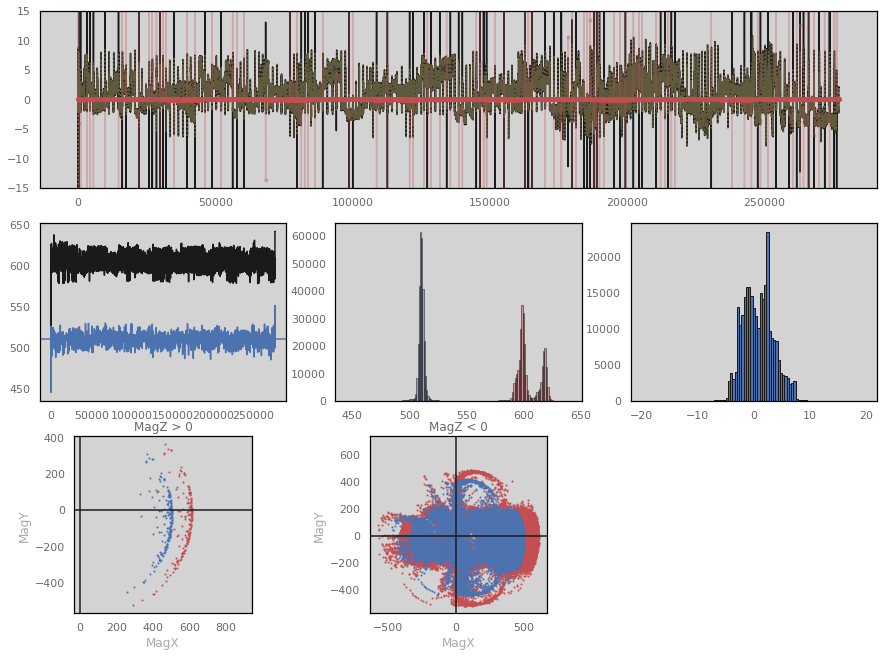

In [6]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## Perform soundspeed correction

In [7]:
ADCP = process_adcp.soundspeed_correction(ADCP)

2023-05-23 11:01:16 : Corrected beam 1 velocity for sound speed.
2023-05-23 11:01:16 : Corrected beam 2 velocity for sound speed.
2023-05-23 11:01:16 : Corrected beam 3 velocity for sound speed.
2023-05-23 11:01:16 : Corrected beam 4 velocity for sound speed.


## Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

2023-05-23 11:01:20 : Beam 1 correlation: 43.8% removed
2023-05-23 11:01:20 : Beam 1 amplitude: 0.8% removed
2023-05-23 11:01:20 : Beam 1 velocity: 1.7% removed
2023-05-23 11:01:20 : Beam 2 correlation: 44.9% removed
2023-05-23 11:01:20 : Beam 2 amplitude: 0.7% removed
2023-05-23 11:01:20 : Beam 2 velocity: 1.8% removed
2023-05-23 11:01:20 : Beam 3 correlation: 46.0% removed
2023-05-23 11:01:20 : Beam 3 amplitude: 0.7% removed
2023-05-23 11:01:21 : Beam 3 velocity: 2.1% removed
2023-05-23 11:01:21 : Beam 4 correlation: 43.8% removed
2023-05-23 11:01:21 : Beam 4 amplitude: 0.7% removed
2023-05-23 11:01:21 : Beam 4 velocity: 1.7% removed


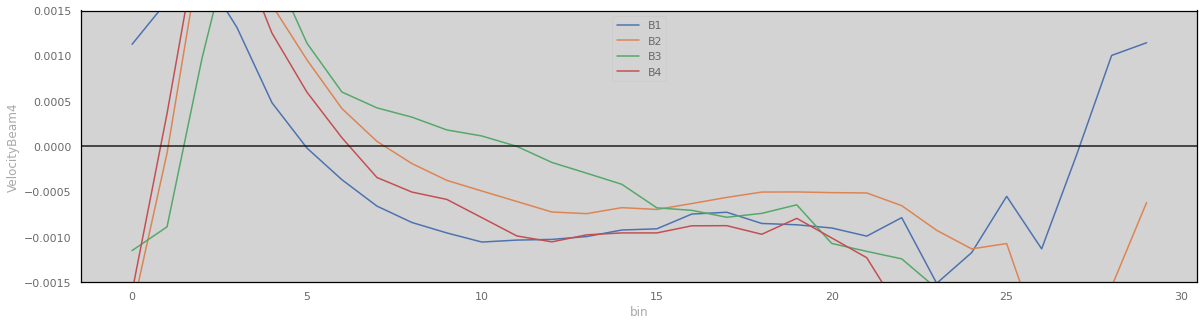

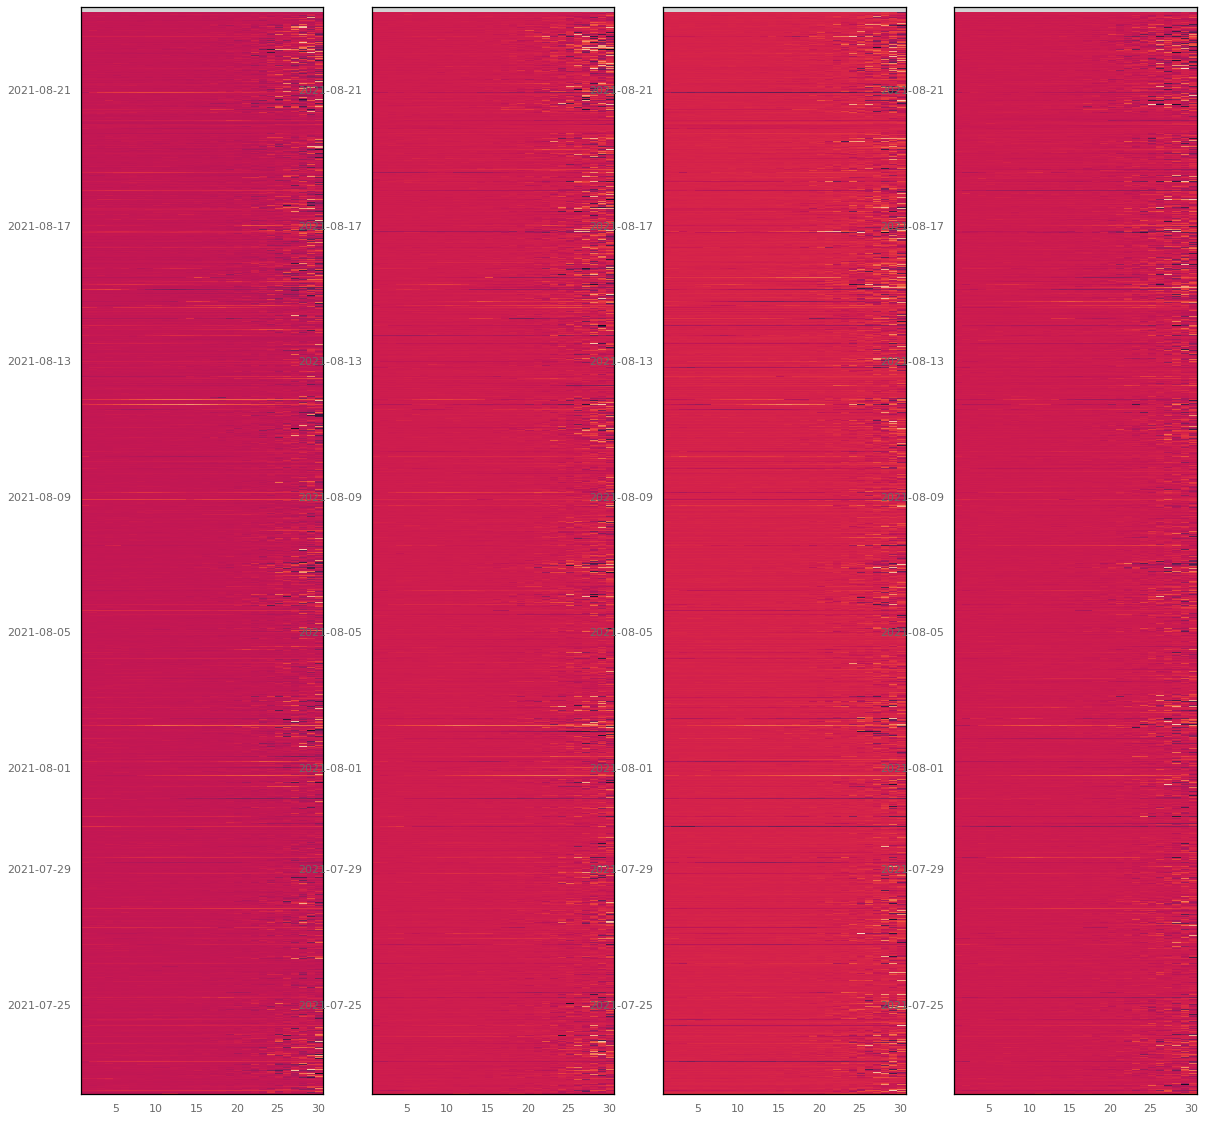

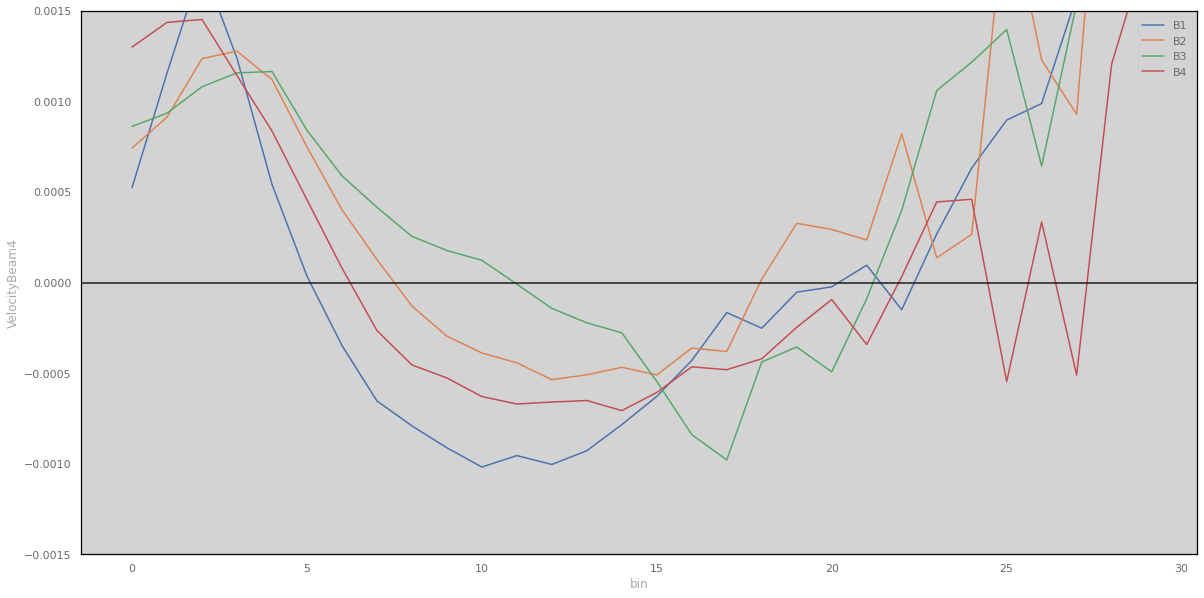

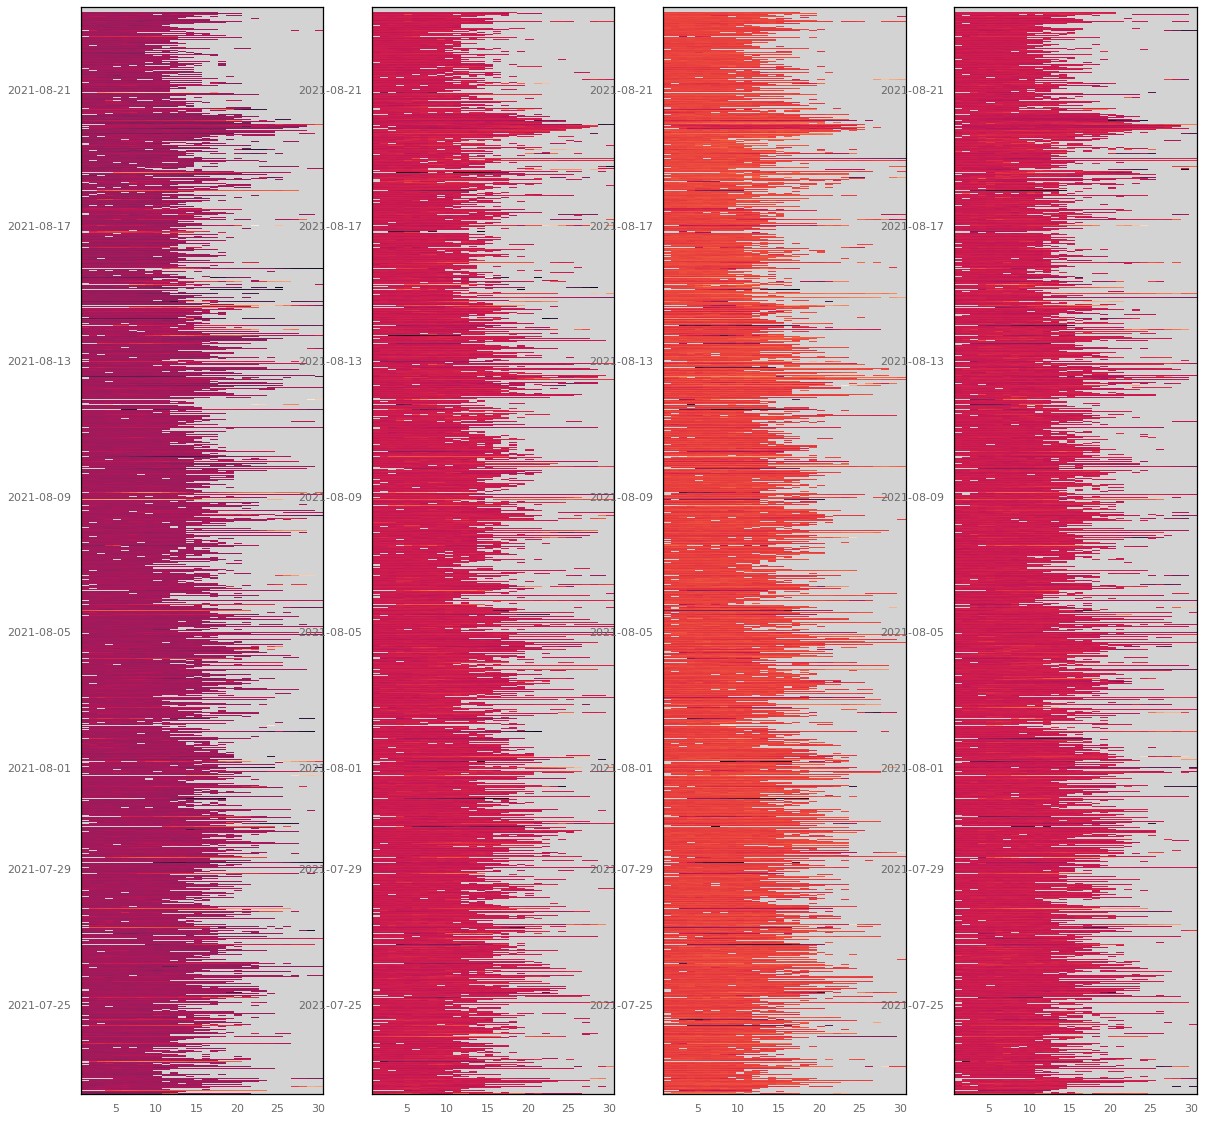

In [8]:
ADCP = process_adcp.remove_outliers(ADCP, options)

Should we interpolate over bad data? Reconstruct missing bins in profiles?

# How many good data per bin?

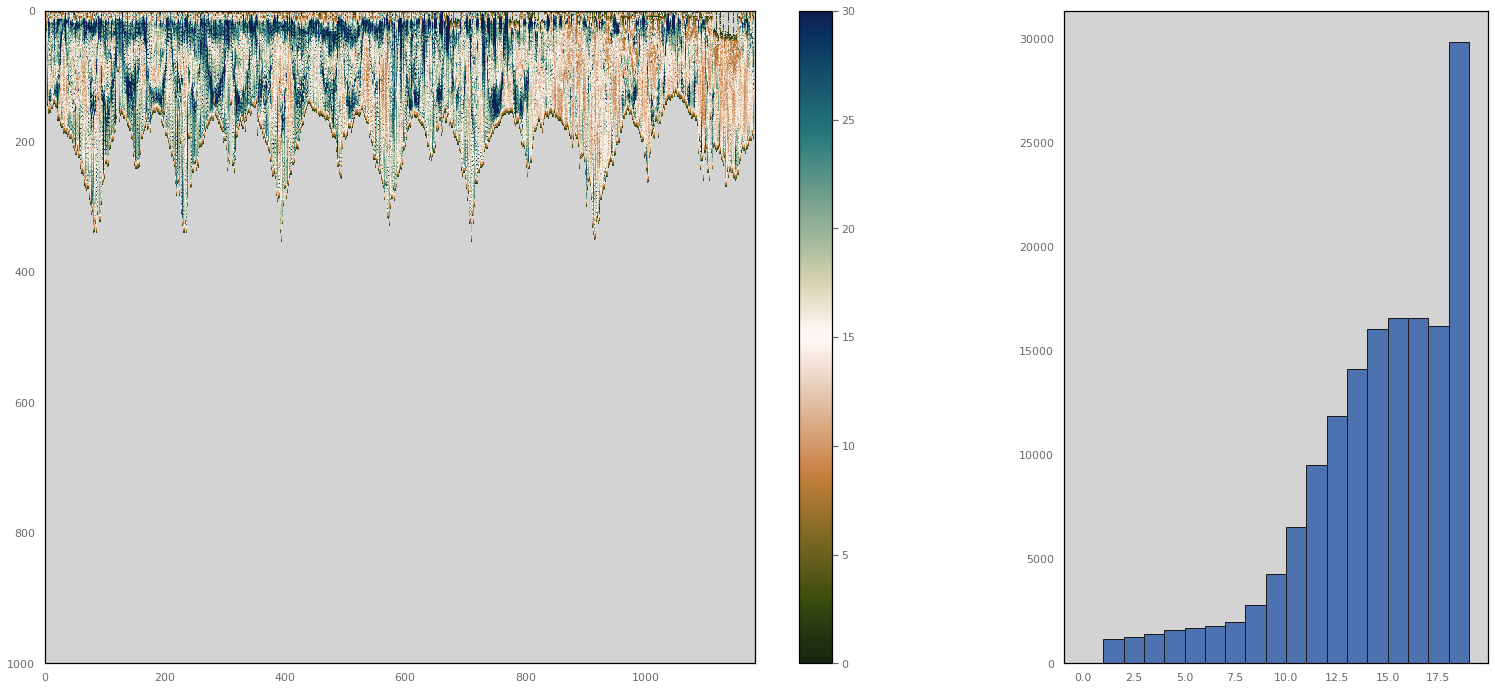

In [9]:
process_adcp.plot_data_density(ADCP, ADCP_settings)

### Correct shear bias

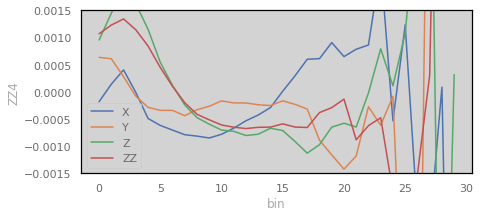

In [10]:
ADCP = process_adcp.correct_shear(ADCP, options)

### Pitching motion correction (TODO - or not TODO)

In [11]:
if options['ADCP_discardFirstBins']: print(ADCP.dims); ADCP = ADCP.isel(bin = ADCP['bin'] >= options['ADCP_discardFirstBins']); print(ADCP.dims); plog('Discarded first '+str(options['ADCP_discardFirstBins'])+' bins from ADCP data')

## 3.4. Correct ADCP acoustic backscatter data (TODO)

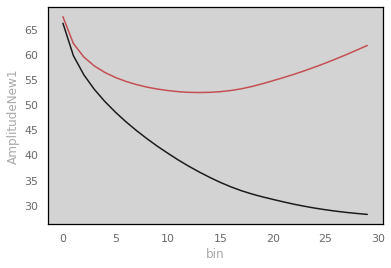

In [12]:
ADCP = process_adcp.correct_backscatter(ADCP, data)

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5]
 
Running gridding on all 4 beams:
2023-05-23 11:02:12 : Calculating beam 1
2023-05-23 11:02:22 : Calculating beam 2
2023-05-23 11:02:31 : Calculating beam 3
2023-05-23 11:02:41 : Calculating beam 4


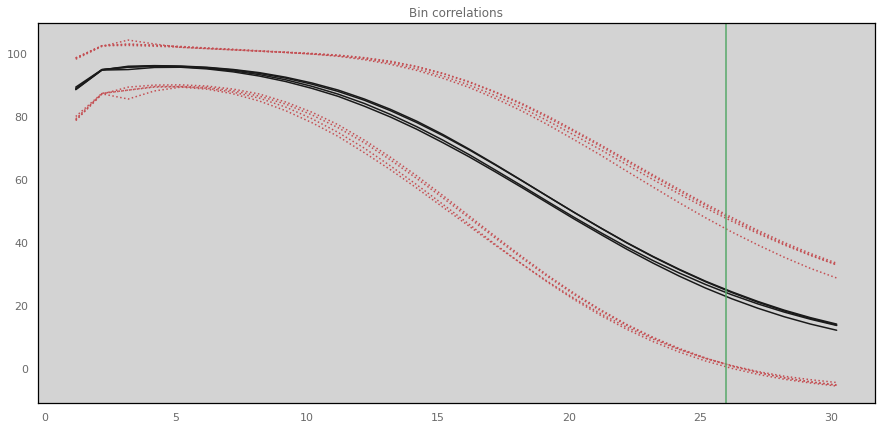

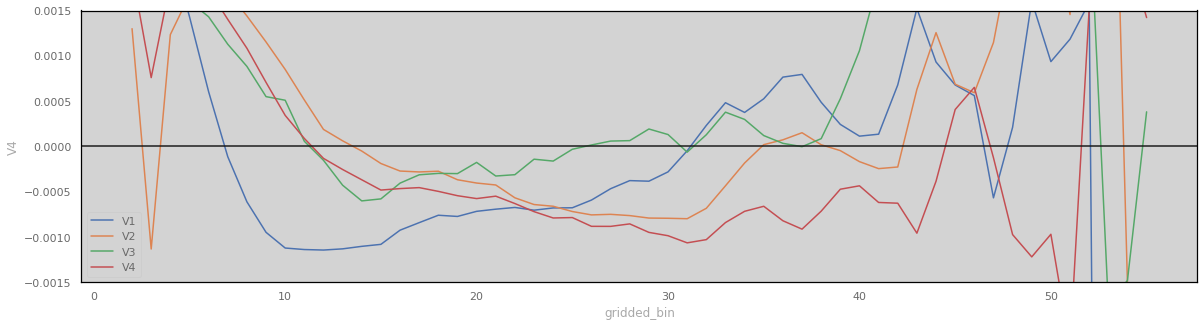

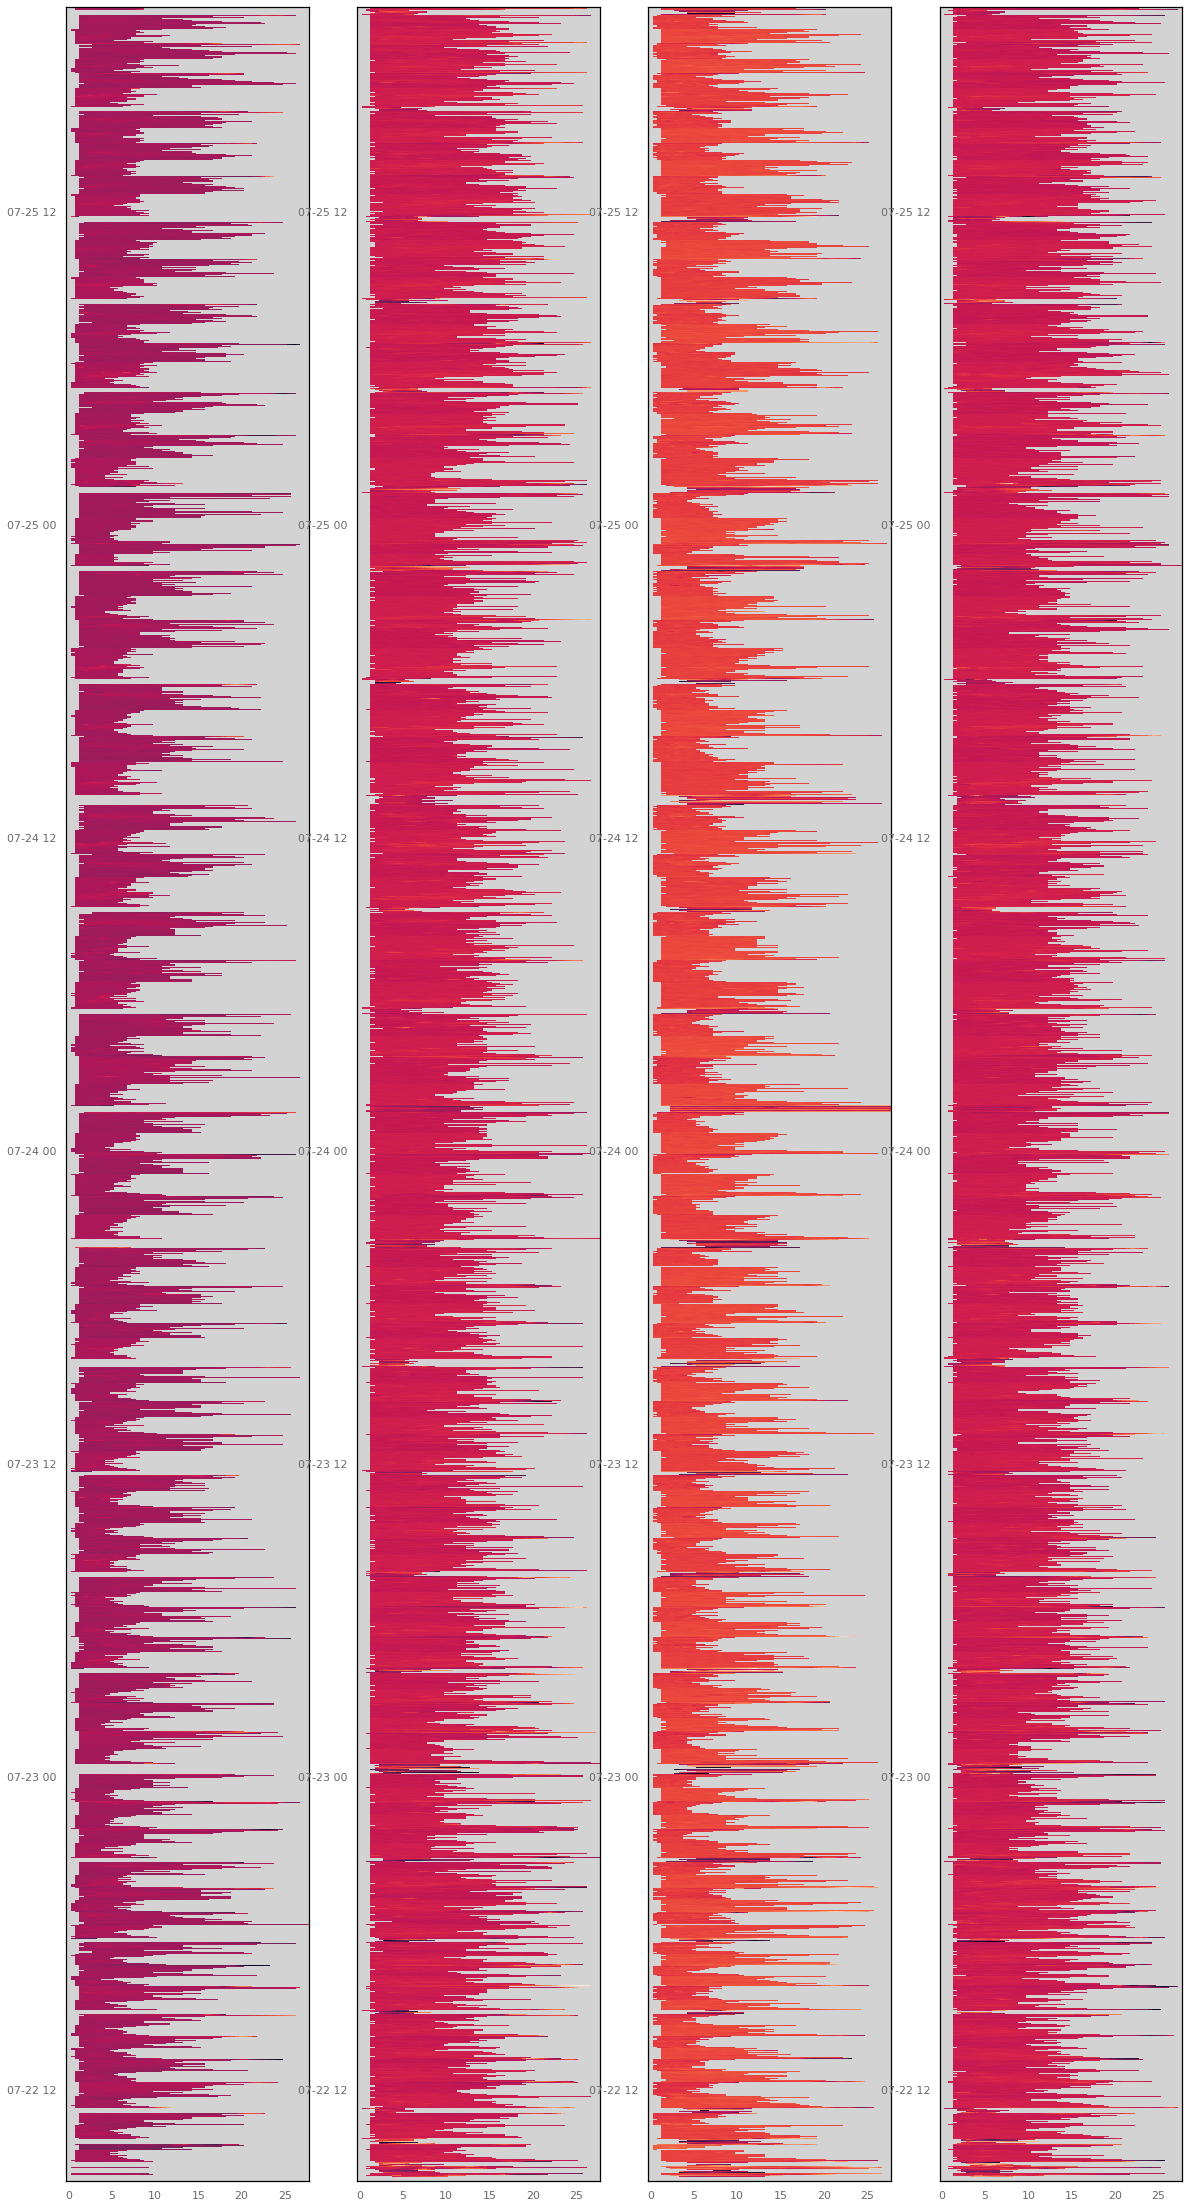

In [13]:
ADCP = process_adcp.regridADCPdata(ADCP, ADCP_settings, options)

## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is top mounted
2023-05-23 11:02:57 : Calculating X,Y,Z from isobaric 3-beam measurements.


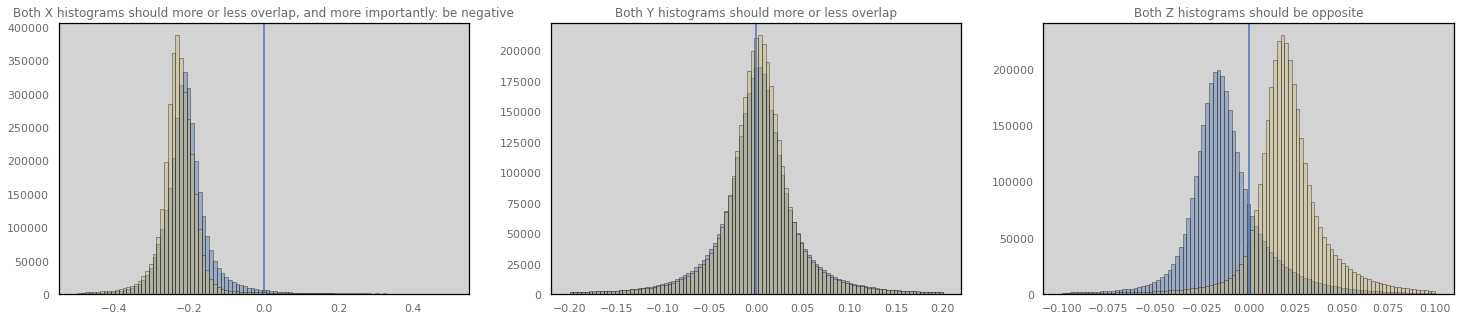

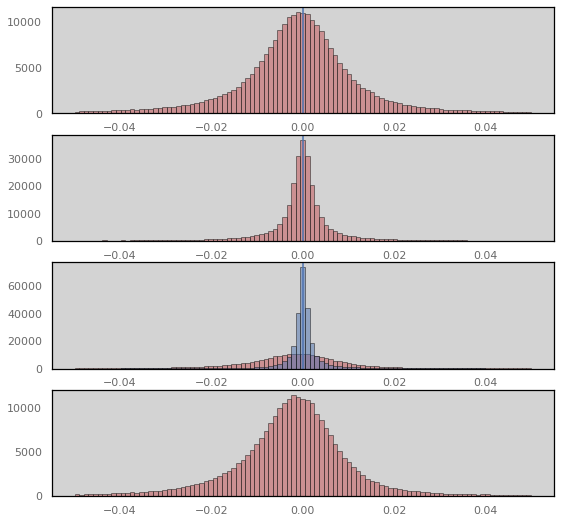

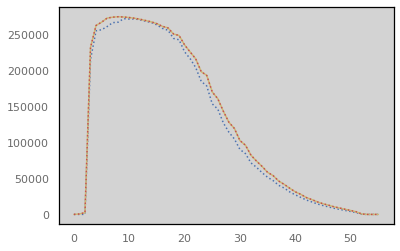

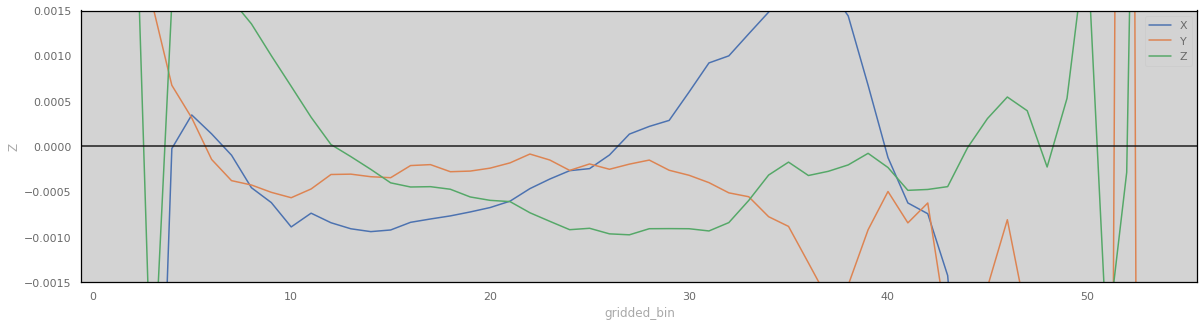

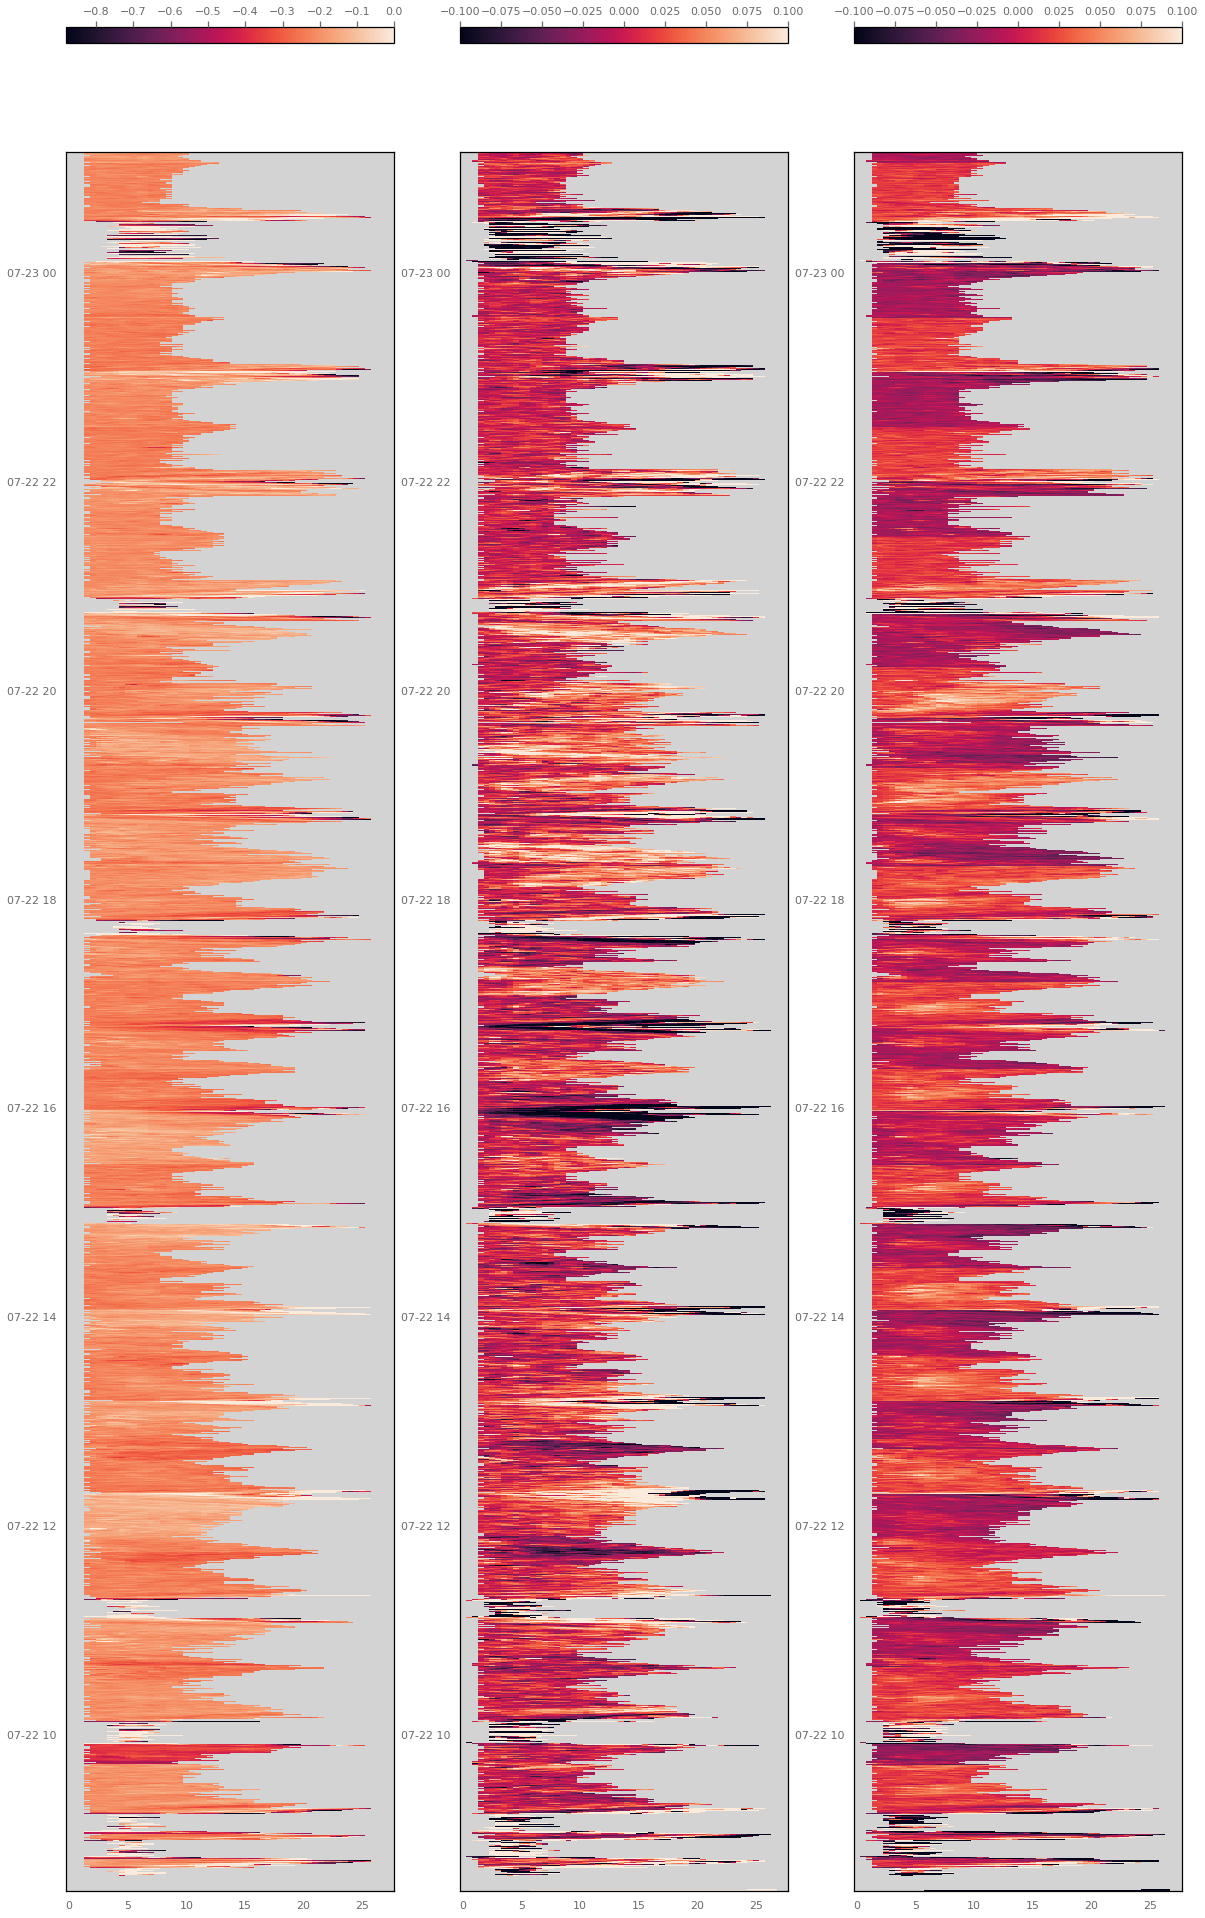

In [14]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

2023-05-23 11:03:01 : Converted from XYZ to ENU


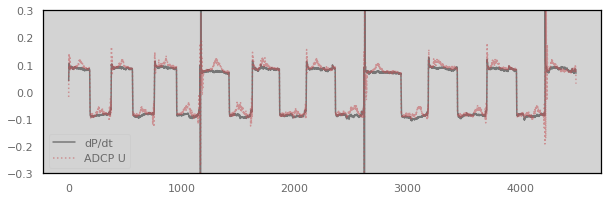

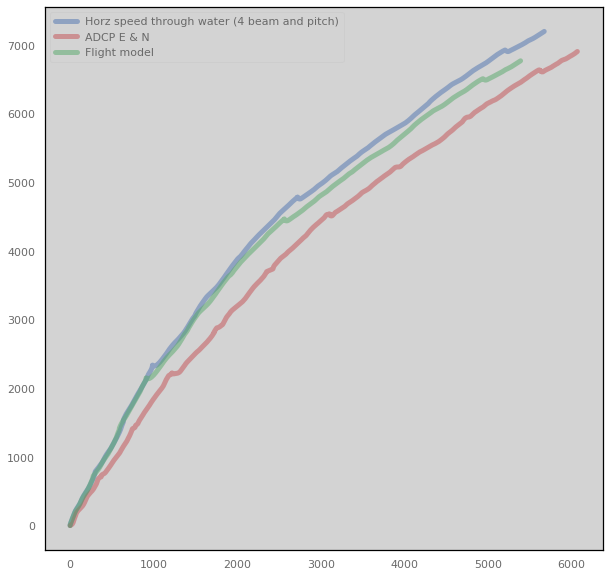

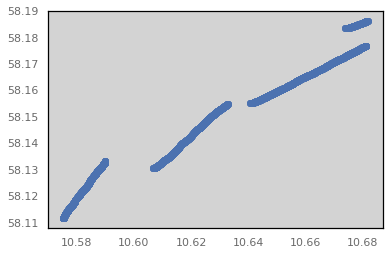

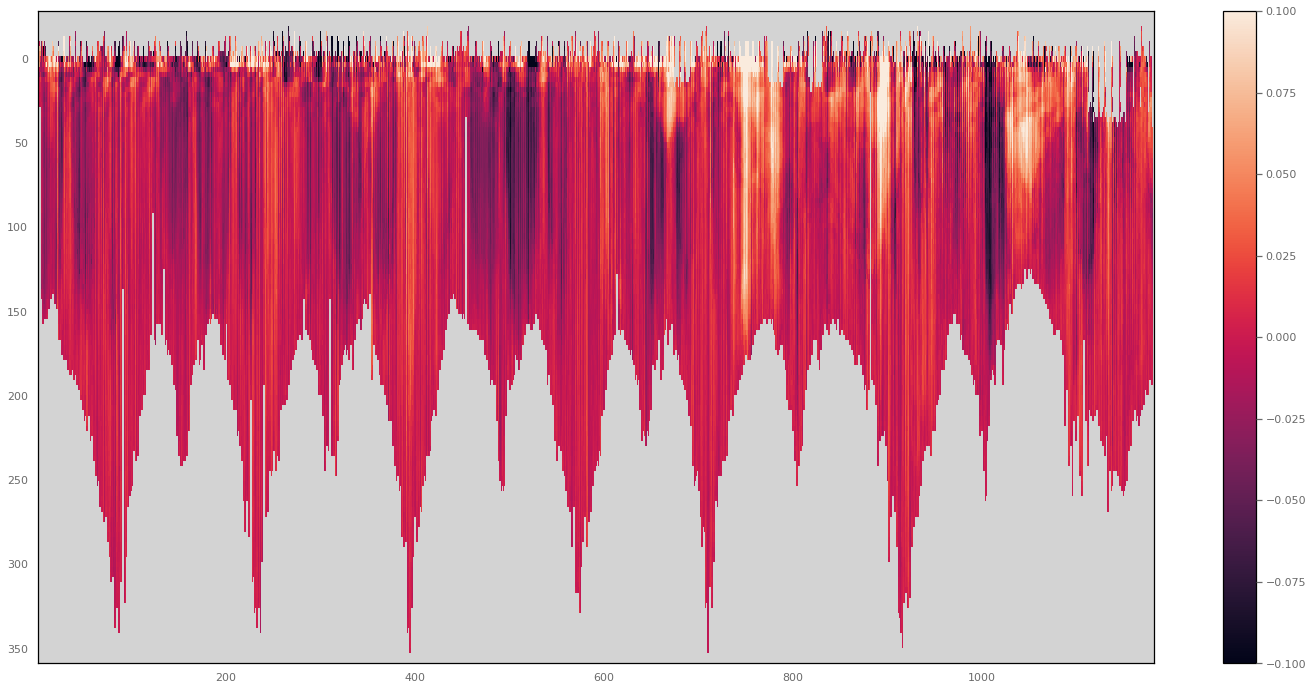

In [15]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

## Check if errors in the above are related to motor movements?

131105 126823


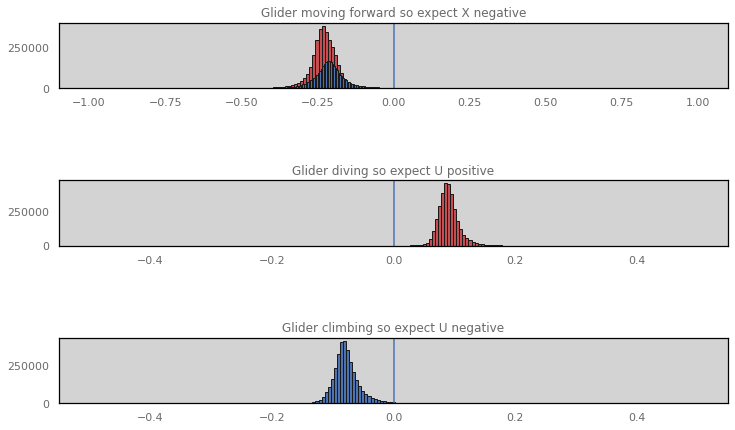

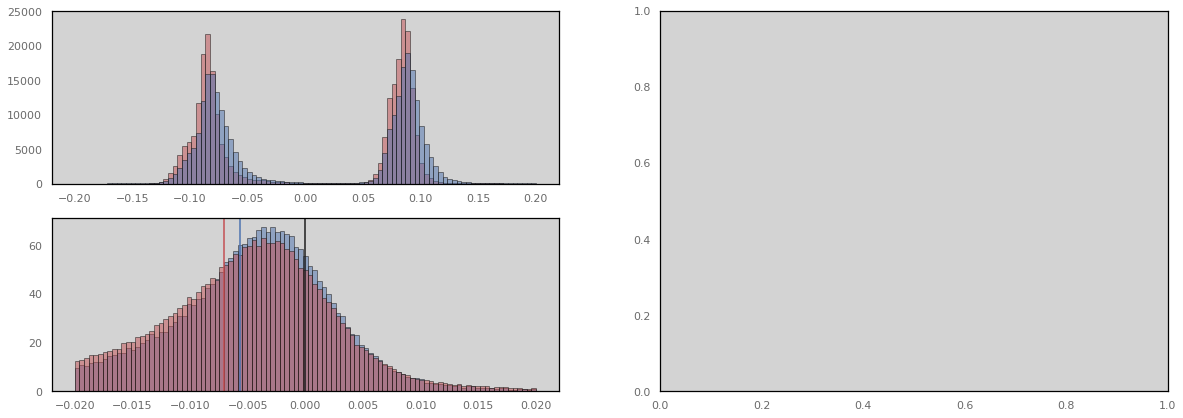

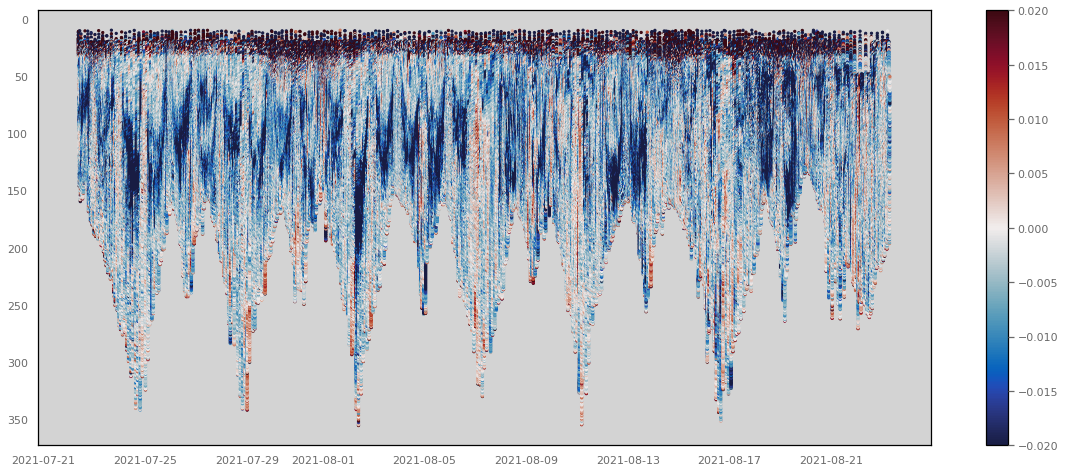

In [16]:
process_adcp.verify_calcENUfromXYZ(ADCP)

### Mismatch above sign of misalignment of ADCP / incorrect pitch/roll ?

## 3.7. Calculate shear

## 5.2. Calculate dive-averaged current

No final GPS for dive 590.0


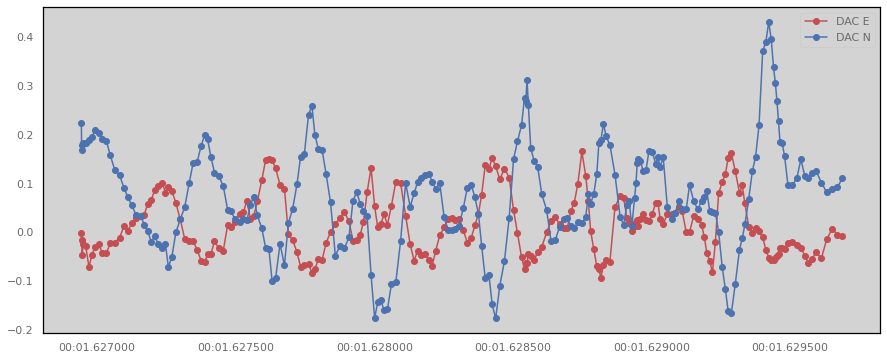

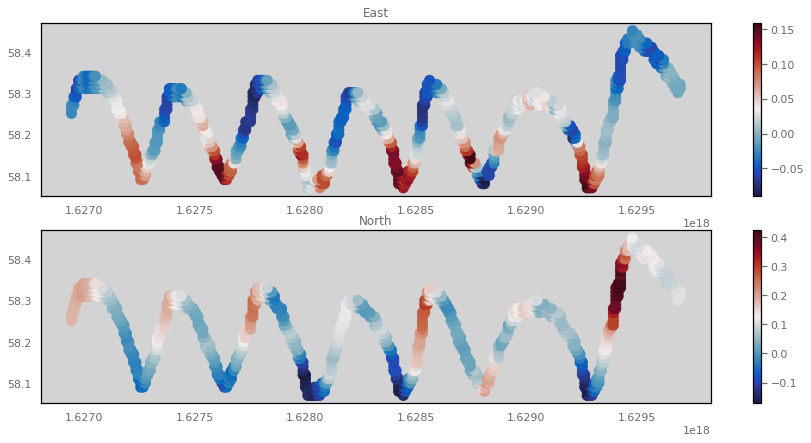

In [17]:
data = process_adcp.get_DAC(ADCP, data)

## 5.3. Get surface drift

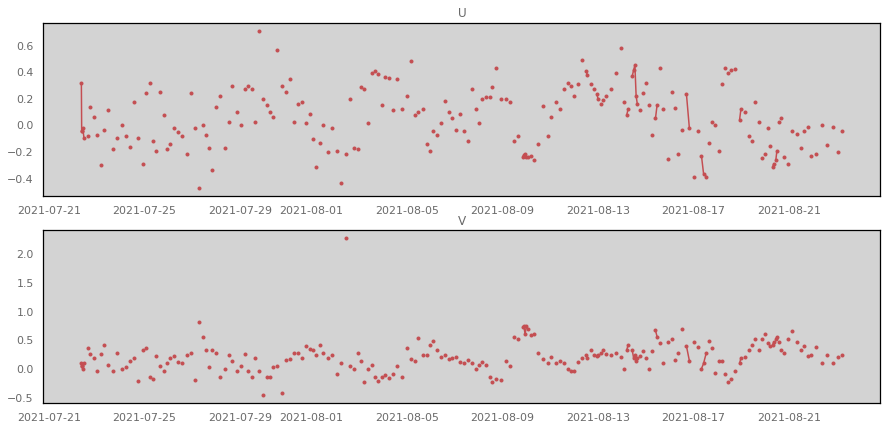

In [18]:
dE,dN,dT = process_adcp.getSurfaceDrift(data)

## 5.4. Get bottom track data

In [19]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1834/1834 [00:01<00:00, 1611.11it/s]


Profile 0 was empy
Profile 883 was empy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 20827.56it/s]


## 5.5. Reference ADCP data

/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1534: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, V, cmap=cmo.balance, shading='auto')
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1538: UserWarning: No contour levels were found within the data range.
  plt.contour(taxis, yaxis, SA, np.linspace(35.5, 38.5, 6), colors='k', alpha=0.3)
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1534: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, ya

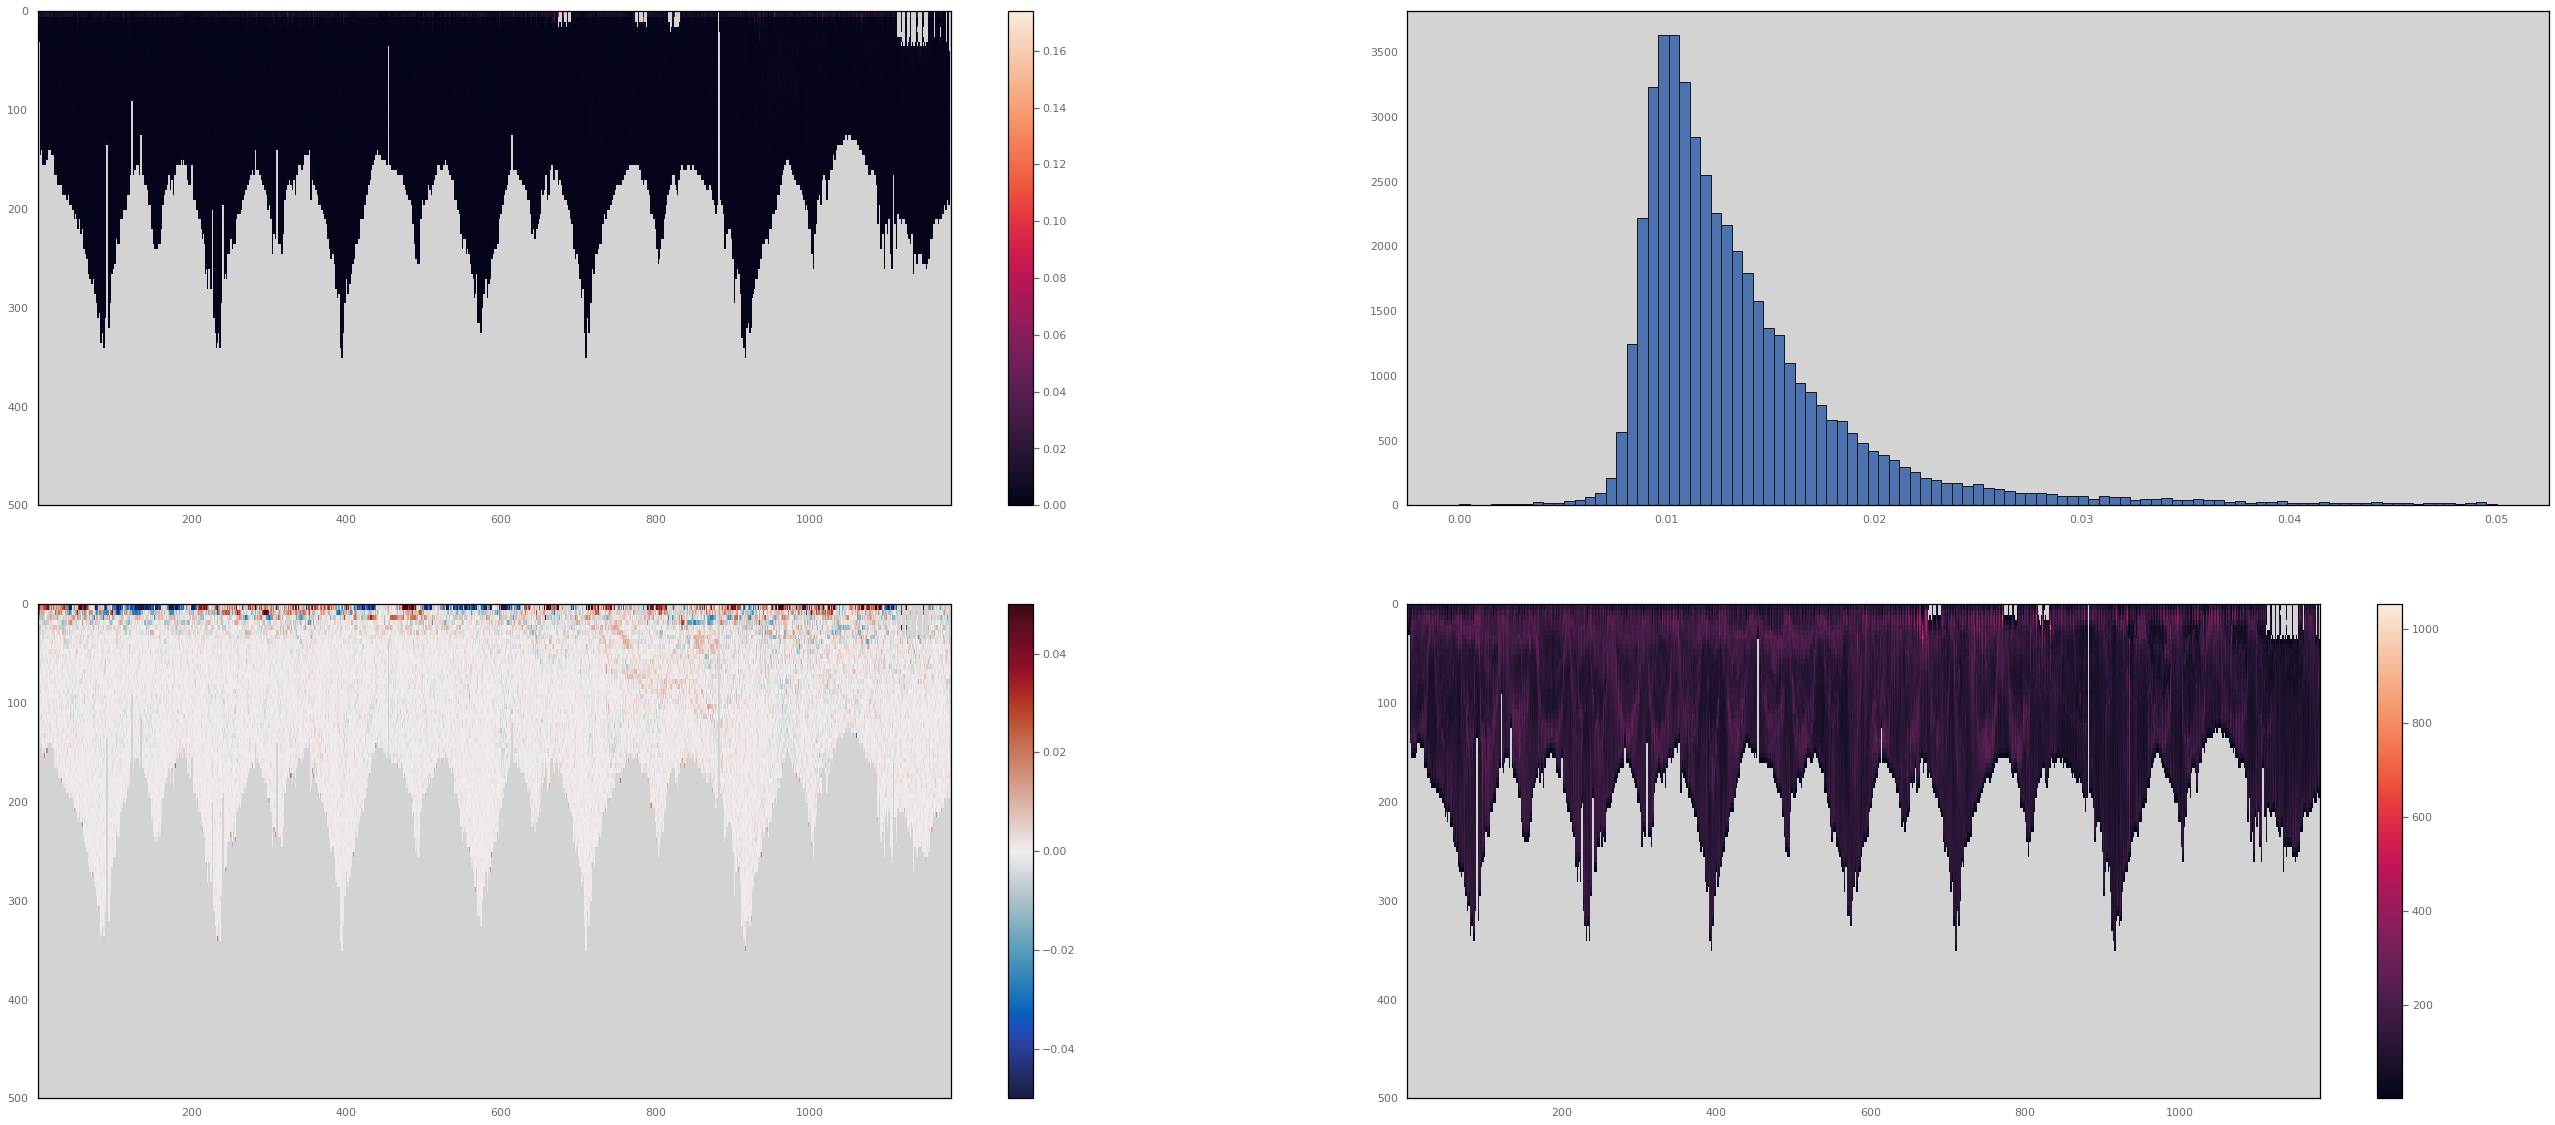

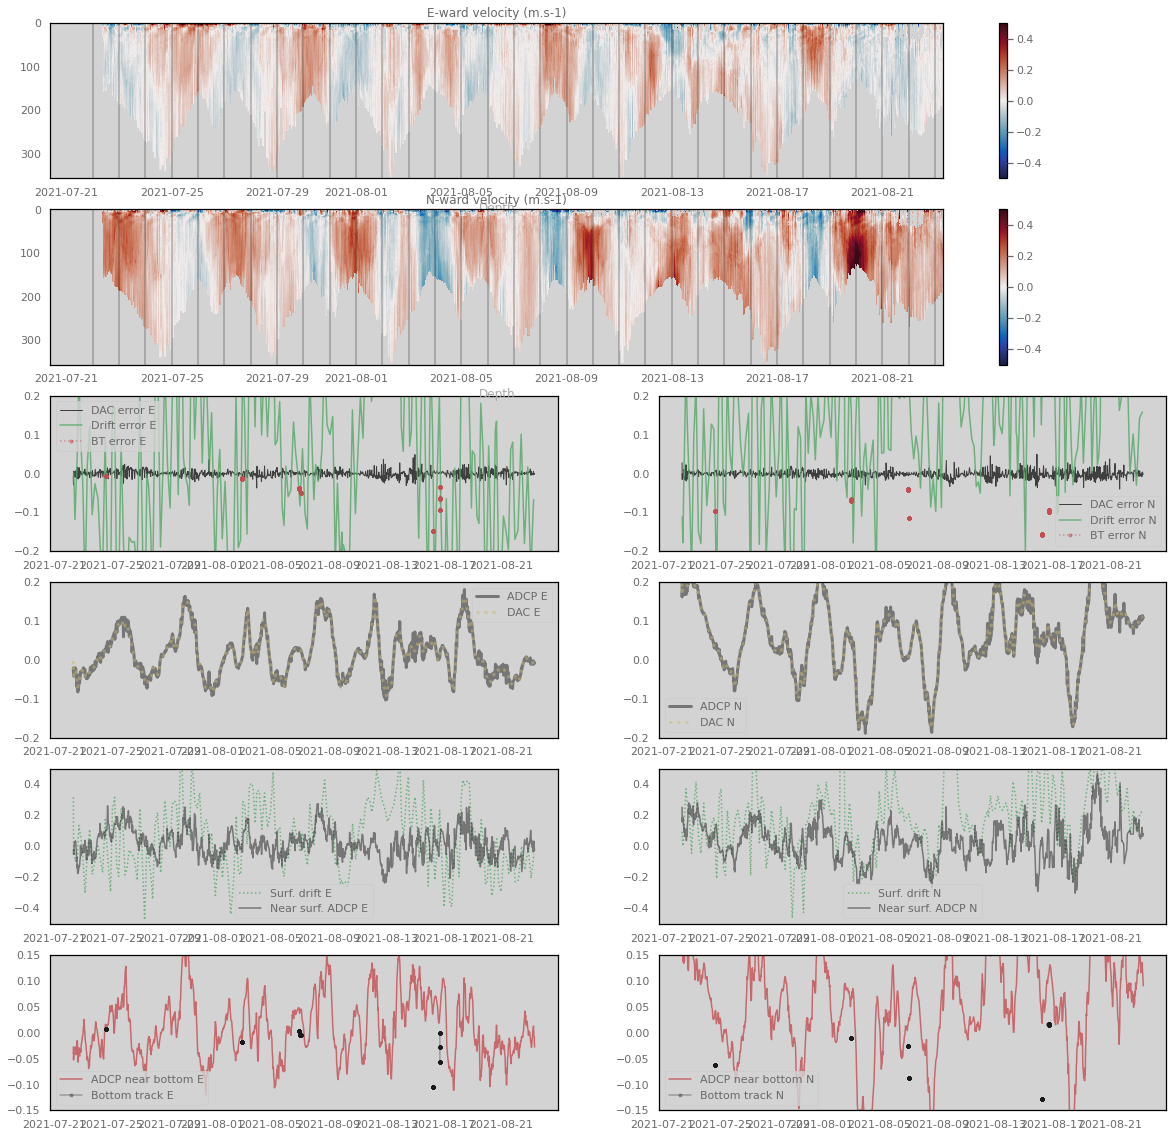

In [20]:
out, xaxis, yaxis, taxis, days = process_adcp.verify_bottom_track(ADCP, data, dE,dN,dT )

# VI. Grid and plot data

In [21]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.26it/s]


/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1663: RuntimeWarning: invalid value encountered in remainder
  up = np.remainder(out['profileNum'], 2) == 0
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1664: RuntimeWarning: invalid value encountered in remainder
  down = np.remainder(out['profileNum'], 2) == 1


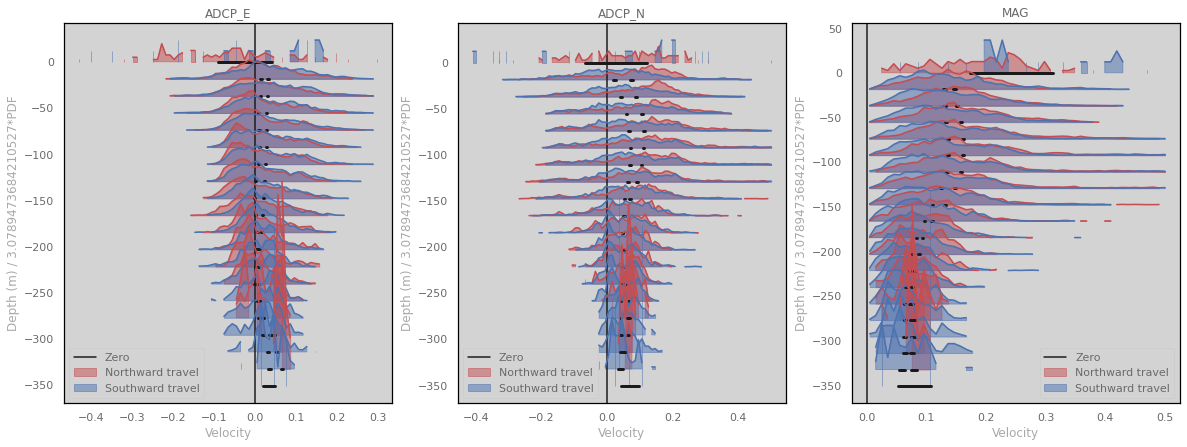

In [22]:
process_adcp.verify_depth_bias(out, yaxis)

 27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 27/100 [00:00<00:01, 36.76it/s]


Optimization terminated successfully.
         Current function value: 168411.665266
         Iterations: 27
         Function evaluations: 54
(array([0.00148258]), 168411.6652655584, 27, 54, 0)


/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1663: RuntimeWarning: invalid value encountered in remainder
  up = np.remainder(out['profileNum'], 2) == 0
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1664: RuntimeWarning: invalid value encountered in remainder
  down = np.remainder(out['profileNum'], 2) == 1
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1799: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(taxis, yaxis, out['ADCP_E'], cmap=cmo.balance, shading='auto')
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1803: UserWarning: No contour levels were found within the data range.
  plt.contour(taxis, yaxis, out['sa'], np.linspace(35.5

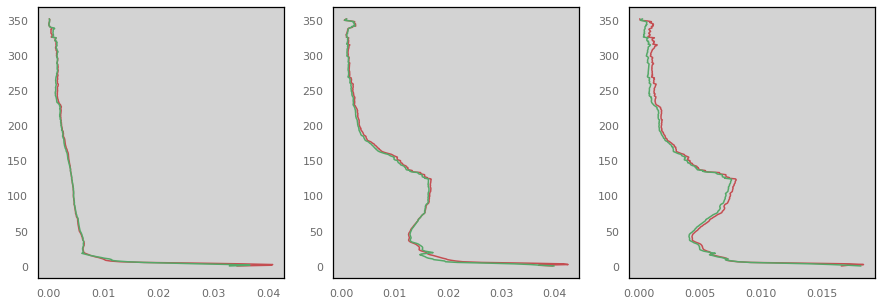

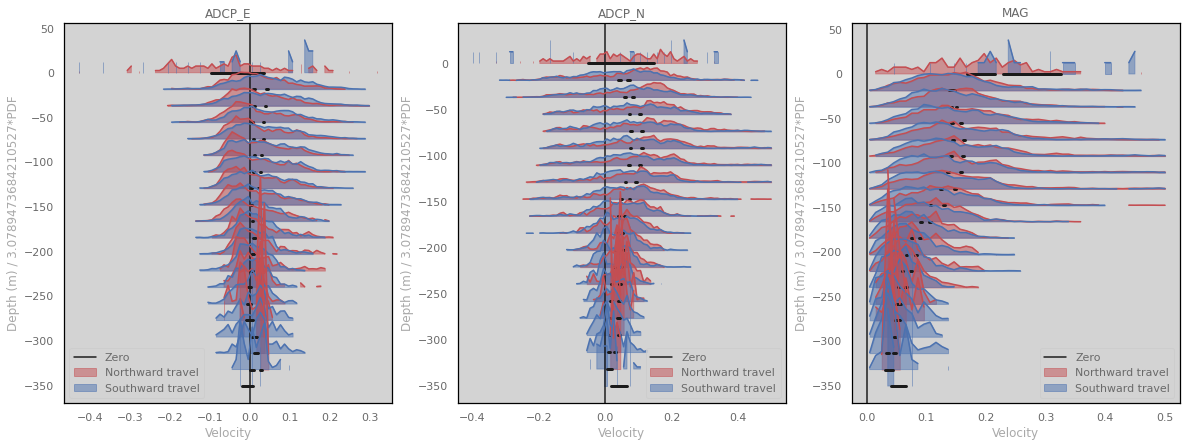

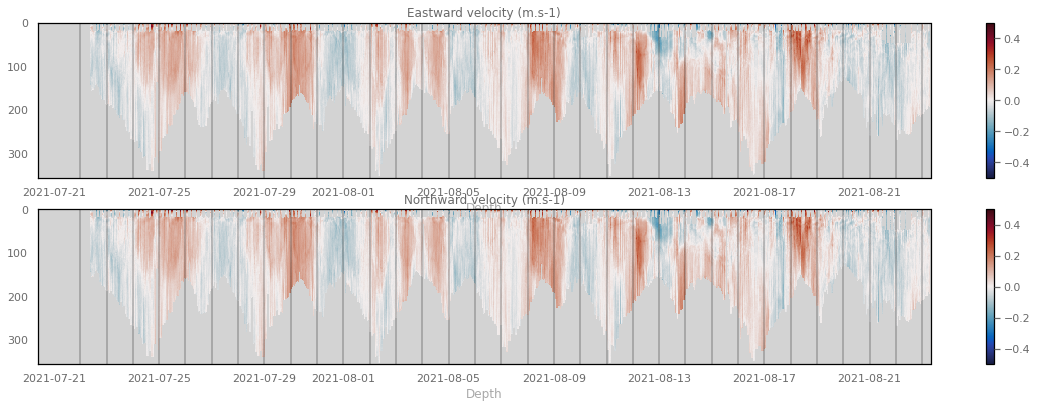

In [23]:
out = process_adcp.calc_bias(out, yaxis, taxis, days)

# Create xarray DataSet from `out` and compare results

In [24]:
import xarray as xr
import numpy as np
profiles = np.arange(out["Pressure"].shape[1])
depth_bins = np.arange(out["Pressure"].shape[0])

ds_dict = {}
for key, val in out.items():
    ds_dict[key] = (( "depth_bin", "profile_num",), val)
coords_dict = {"profile_num": (("profile_num"), profiles),
               "depth_bin": (("depth_bin"), depth_bins)
}
ds = xr.Dataset(data_vars=ds_dict, coords=coords_dict)
ds_min = ds[['Sh_E', 'Sh_N','Sh_U', 'ADCP_E', 'ADCP_N']]

In [25]:
ds_min_test = xr.open_dataset("tests/test_files/ds_out_min.nc")

The processing chain uses some non-determinate functions that can produce small numerical differences in results, so we test with `numpy.allclose` rather than `equals`

In [26]:
for var in list(ds_min):
    assert np.allclose(ds_min[var], ds_min_test[var], equal_nan=True, atol=1e-7, rtol=1e-3)

## SHEAR BIAS NOTES AND THOUGHTS

Side lobe interference: strong fish signal in front causes apparent upwelling on downward facing ADCP because Beam 1 sees strong negative velocity component. Sidelobe in beams 2 and 4 introduces strong negative velocity. Strong negative velocity in Beam 1 2 and 4 means upwelling (or downwelling with upward facing adcp).

So what if strong 0 velocity observed in beams 2 and 4 (because orthogonal to X) means strong 0 doppler in beams 1 and 3 which introduces bias velocity measurement?